In [132]:
from active_critic.utils.gym_utils import sample_expert_transitions
import torch as th
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
import gym
from imitation.data.wrappers import RolloutInfoWrapper
from stable_baselines3.common.policies import BaseModel
from typing import Any, Dict, List, Optional, Tuple, Type, TypeVar, Union
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
import torch.nn as nn
from active_critic.utils.gym_utils import DummyExtractor
import numpy as np
from active_critic.utils.gym_utils import make_policy_dict
from metaworld.envs import ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE
from gym.wrappers import TimeLimit
from active_critic.utils.pytorch_utils import detokenize, tokenize, calcMSE
from stable_baselines3 import SAC
from active_critic.utils.tboard_graphs import TBoardGraphs
import stable_baselines3
import random
import copy

from stable_baselines3.common.torch_layers import FlattenExtractor
class TestExtractor(FlattenExtractor):
    def __init__(self, observation_space) -> None:
        super().__init__(observation_space)
        self._features_dim = observation_space.shape[0]
        self.initial_phase = True
        self.emitter = None

    def forward(self, observations):
        ext_obsv = super().forward(observations)
        result = th.zeros([*ext_obsv.shape[:-1], self._features_dim], device=ext_obsv.device, dtype=ext_obsv.dtype)

        with th.no_grad():
            if (not self.initial_phase) and (observations.flatten()[-1] == 0):
                embedding = self.emitter(result)
            else:
                embedding = ext_obsv
            
            
        if len(observations.shape) == 1:
            result[:embedding.shape[0]] = embedding
        else:
            result[:, :embedding.shape[1]] = embedding
        return result

def quantize(inpt, minimum, maximum, nquants):
    return inpt
    '''scale = maximum - minimum
    rec_inpt = ((inpt - minimum) / scale)*(nquants-1)
    rounded = th.round(rec_inpt)
    result = (rounded / (nquants - 1))*scale
    return result'''


class MDPData(th.utils.data.Dataset):
    def __init__(self, device) -> None:
        super().__init__()
        self.obsv = None
        self.action = None
        self.reward = None
        self.done = None
        self.device = device

    def add_step(self, obsv:th.Tensor, action:th.Tensor, reward:th.Tensor, done:th.Tensor):
        if self.obsv is None:
            self.obsv = obsv.reshape([1, -1]).to(self.device)
        else:
            self.obsv = th.cat((self.obsv, obsv.to(self.device).reshape([1, -1])), dim=0)

        if self.action is None:
            self.action = action.to(self.device).reshape([1, -1])
        else:
            self.action = th.cat((self.action, action.to(self.device).reshape([1, -1])), dim=0)

        if self.reward is None:
            self.reward = reward.to(self.device).reshape([1, -1])
        else:
            self.reward = th.cat((self.reward, reward.to(self.device).reshape([1, -1])), dim=0)

        if self.done is None:
            self.done = done.to(self.device).reshape([1])
        else:
            self.done = th.cat((self.done, done.to(self.device).reshape([-1])), dim=0)

    def __len__(self):
        return len(self.obsv)

    def __getitem__(self, index):
        done = self.done[index]

        if done:
            return self.obsv[index], th.zeros_like(self.obsv[index]), self.action[index], th.zeros_like(self.action[index]), self.reward[index], th.zeros_like(self.reward[index]), done
        else:
            return self.obsv[index], self.obsv[index+1], self.action[index], self.action[index+1], self.reward[index], self.reward[index+1], done

class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, quantisation=0, activation=nn.ReLU(), dropout=0, use_batch_norm=False):
        super(MLP, self).__init__()
        
        # create a sequential container to hold the layers
        self.layers = nn.Sequential()
        
        # create the input layer
        self.layers.add_module("input", nn.Linear(input_size, hidden_sizes[0]))
        
        # create the hidden layers
        for i, size in enumerate(hidden_sizes[1:]):
            self.layers.add_module(f"hidden_{i+1}", nn.Linear(hidden_sizes[i], size))
            if use_batch_norm:
                self.layers.add_module(f"batch_norm_{i+1}", nn.BatchNorm1d(size))
            self.layers.add_module(f"activation_{i+1}", activation)
            if dropout > 0:
                self.layers.add_module(f"dropout_{i+1}", nn.Dropout(dropout))
        
        # create the output layer
        self.layers.add_module("output", nn.Linear(hidden_sizes[-1], output_size))
        self.quantisation = quantisation
    
    def forward(self, x):
        x_shape = x.shape
        quantized = len(x_shape) == 4
        if quantized: #quantized input
            x = x.reshape([x.shape[0], x.shape[1], -1])
        # forward pass through the layers

        result = self.layers(x)
        if self.quantisation != 0:
            result = result.reshape([x_shape[0], x_shape[1], -1, self.quantisation])
        return result

class MDPLearner(nn.Module):
    def __init__(
        self, 
        embbed_size, 
        ntokens_obsv, 
        ntokens_act, 
        observation_space, 
        action_space, 
        min_obsv,
        max_obsv,
        min_action,
        max_action,
        embedding_decimals:int,  
        device:str, 
        max_batch_size = 64) -> None:

        
        super().__init__()
        obsv_size = observation_space.shape[0]
        action_size = action_space.shape[0]

        hidden_size = 128

        self.emitter = MLP(input_size=obsv_size, hidden_sizes=[hidden_size, hidden_size, hidden_size], output_size=embbed_size, quantisation=0).to(device)
        self.predictor = MLP(input_size=(embbed_size+action_size), hidden_sizes=[hidden_size, hidden_size, hidden_size], output_size=embbed_size, quantisation=0).to(device)
        self.reward_model = MLP(input_size=(embbed_size+action_size), hidden_sizes=[hidden_size, hidden_size, hidden_size], output_size=1, quantisation=0).to(device)
        
        self.optimizer = th.optim.Adam(params=list(self.emitter.parameters()) + list(self.predictor.parameters())+ list(self.reward_model.parameters()), lr=1e-4)
        self.scheduler = th.optim.lr_scheduler.StepLR(optimizer=self.optimizer, step_size=300000/32, gamma=0.95)
        self.obs_minimum = min_obsv.to(device)
        self.obs_maximum = max_obsv.to(device)
        self.action_minimum = min_action.to(device)
        self.action_maximum = max_action.to(device)
        self.ntokens_obsv = ntokens_obsv
        self.ntokens_act = ntokens_act
        self.embbed_size = embbed_size

        self.embedding_decimals = embedding_decimals

        self.obs_minimum = self.obs_minimum.reshape([1,1,-1]).repeat([max_batch_size, 1, 1]).to(device)
        self.obs_maximum = self.obs_maximum.reshape([1,1,-1]).repeat([max_batch_size, 1, 1]).to(device)
        self.action_minimum = self.action_minimum.reshape([1,1,-1]).repeat([max_batch_size, 1, 1]).to(device)
        self.action_maximum = self.action_maximum.reshape([1,1,-1]).repeat([max_batch_size, 1, 1]).to(device)

        self.device = device

    def qemb_qact_f_obsv(self, obsvs, actions):
        batch_size = actions.shape[0]
        qobsvs = quantize(obsvs, minimum=self.obs_minimum[:batch_size], maximum=self.obs_maximum[:batch_size], nquants=self.ntokens_act)
        embeddings = self.emitter.forward(qobsvs)
        return self.get_q_emb_q_act(embeddings=embeddings, actions=actions)

    def get_q_emb_q_act(self, embeddings, actions):
        batch_size = actions.shape[0]
        qactions = quantize(actions, minimum=self.action_minimum[:batch_size], maximum=self.action_maximum[:batch_size], nquants=self.ntokens_act)
        #qembeddings = th.round(embeddings, decimals=self.embedding_decimals)
        qembeddings = embeddings
        emb_act = th.cat((qembeddings, qactions), dim=2)
        return emb_act, qembeddings


    def learn_step(self, obsvs:th.Tensor, n_obsvs:th.Tensor, actions:th.Tensor, n_actions:th.Tensor, rewards:th.Tensor, n_rewards:th.Tensor, dones:th.Tensor):
        #Inputs are step wise, so seq_len = 1
        obsvs = obsvs.unsqueeze(1)
        n_obsvs = n_obsvs.unsqueeze(1)
        actions = actions.unsqueeze(1)
        n_actions = n_actions.unsqueeze(1)
        rewards = rewards.unsqueeze(1)
        n_rewards = n_rewards.unsqueeze(1)

        #Reshape the maximum and minimum according to batch size

        nd_n_actions = n_actions[~dones]
        nd_n_observations = n_obsvs[~dones]
        nd_nrewards = n_rewards[~dones]

        '''print(f'actions: {actions.shape}')
        print(f'obsvs: {obsvs.shape}')
        print(f'rewards: {rewards.shape}')
        print(f'actions: {actions.shape}')
        print(f'nd_n_actions: {nd_n_actions.shape}')
        print(f'nd_n_observations: {nd_n_observations.shape}')
        print(f'nd_nrewards: {nd_nrewards.shape}')
        print(f'dones: {dones.shape}')'''


        rew1_loss, emb_act1, embeddings1, expected_rewards1 = self.step_reward_model(actions=actions, observations=obsvs, rewards=rewards, do_print=False)
        rew2_loss, emb_act2, q_embeddings2, expected_rewards2 = self.step_reward_model(actions=nd_n_actions, observations=nd_n_observations, rewards=nd_nrewards, do_print=False)
        
        nd_emb_act1 = emb_act1[~dones]

        pred_loss, pred_n_embeddings = self.step_predictor(emb_act=nd_emb_act1, n_embeddings=q_embeddings2)

        pred_rew2_loss, _, _, _ = self.step_predictive_reward_model(actions=nd_n_actions, embeddings=pred_n_embeddings, rewards=nd_nrewards, do_print=False)


        loss = rew1_loss + rew2_loss + pred_loss + pred_rew2_loss


        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.scheduler.step()

        #q_pred_embeddings2 = th.round(pred_n_embeddings, decimals=self.embedding_decimals)
        q_pred_embeddings2 = pred_n_embeddings
        return rew1_loss.detach(), rew2_loss.detach(), pred_loss.detach(), q_embeddings2.detach(), q_pred_embeddings2.detach(), pred_rew2_loss.detach()

    def step_reward_model(self, actions:th.Tensor, observations:th.Tensor, rewards:th.Tensor, do_print:bool):
        emb_act, qembeddings = self.qemb_qact_f_obsv(obsvs=observations, actions=actions)
        expected_rewards = self.reward_model.forward(emb_act)

        loss = calcMSE(expected_rewards, rewards)
        return loss, emb_act, qembeddings, expected_rewards

    def step_predictive_reward_model(self, actions:th.Tensor, embeddings:th.Tensor, rewards:th.Tensor, do_print:bool):
        emb_act, qembeddings = self.get_q_emb_q_act(embeddings=embeddings, actions=actions)
        expected_rewards = self.reward_model.forward(emb_act)

        loss = calcMSE(expected_rewards, rewards)
        return loss, emb_act, qembeddings, expected_rewards

    def step_predictor(self, emb_act:th.Tensor, n_embeddings:th.Tensor):

        pred_n_embeddings = self.predictor(emb_act)
        pred_loss = calcMSE(pred_n_embeddings, n_embeddings)

        pred_loss = pred_loss.sum() * 100
        return pred_loss, pred_n_embeddings

    def predict_step_embedding(self, embeddings, actions):
        q_emb_q_act, _ = self.get_q_emb_q_act(embeddings=embeddings, actions=actions)

        pred_n_embeddings = self.predictor(q_emb_q_act)
        #q_pred_n_embeddings = th.round(pred_n_embeddings, decimals=self.embedding_decimals)
        q_pred_n_embeddings = pred_n_embeddings
        return q_pred_n_embeddings, q_emb_q_act

    def pred_n_steps(self, obsv, actions):
        rewards = []
        embeddings = []
        steps = actions.shape[1]

        obsv = obsv.unsqueeze(1)


        q_emb_q_act, qembeddings = self.qemb_qact_f_obsv(obsvs=obsv, actions=actions[:, :1])
        for i in range(steps):
            emb_act, qembeddings = self.get_q_emb_q_act(embeddings=qembeddings, actions=actions[:, i:i+1])
            pred_reward = self.reward_model(emb_act)
            rewards.append(pred_reward)

            q_pred_n_embeddings, _  = self.predict_step_embedding(embeddings=qembeddings, actions=actions[:, i:i+1])
            embeddings.append(q_pred_n_embeddings.detach())
            qembeddings = q_pred_n_embeddings.detach()

        return rewards, embeddings

    def pred_rewards(self, obsvs, actions):
        self.eval()
        q_emb_q_act, qembeddings = self.qemb_qact_f_obsv(obsvs=obsvs, actions=actions)
        rewards = self.reward_model.forward(q_emb_q_act)
        return rewards

    def pred_step(self, embeddings, actions):
        embeddings = self.reshape(embeddings)
        actions = self.reshape(actions)
        n_embedding, currten_emb_act = self.predict_step_embedding(embeddings=embeddings, actions=actions)
        rewards = self.reward_model(currten_emb_act)
        info = {}
        #definitely a hack
        dones = rewards == 10

        #n_embedding = th.round(n_embedding, decimals=self.embedding_decimals)

        return n_embedding.detach(), rewards.detach(), dones.detach(), info

    def reshape(self, inpt):
        if len(inpt.shape) == 1:
            return inpt.reshape([1,1,-1])
        elif len(inpt.shape) == 2:
            return inpt.reshape([inpt.shape[0], 1, -1])
        else:
            return inpt

    def learn(self, max_steps, rew1_thr, rew2_thr, embedd_thr, dataloader:th.utils.data.DataLoader, tboard:TBoardGraphs):
        self.train()
        steps = 0
        l2_rew1 = float('inf')
        l2_rew2 = float('inf')
        n_equal_embedding = float('inf')
        
        while (steps <= max_steps) and ((l2_rew1 > rew1_thr) or (l2_rew2 > rew2_thr) or (n_equal_embedding > embedd_thr)):

            r1l = 0
            r2l = 0
            pr2l = 0
            el2 = 0
            nem = 0
            iteration_counter = 0
            for obsv, nobsv, action, naction, reward, nreward, done in dataloader:
                rew1_loss, rew2_loss, pred_loss, q_embeddings2, q_pred_embeddings2, pred_rew2_loss = self.learn_step(
                    obsvs=obsv, 
                    n_obsvs=nobsv, 
                    actions=action, 
                    n_actions=naction, 
                    rewards=reward,
                    n_rewards=nreward,
                    dones=done)
                steps += obsv.shape[0]
                iteration_counter+= 1
                r1l = r1l + rew1_loss
                r2l = r2l + rew2_loss
                el2 = el2 + pred_loss
                pr2l = pr2l + pred_rew2_loss

                nee = (q_embeddings2 != q_pred_embeddings2).sum()
                nem = nem + nee
                

            l2_rew1 = r1l / iteration_counter
            l2_rew2 = r2l / iteration_counter
            el2 = el2 / iteration_counter
            pr2l = pr2l / iteration_counter
            n_equal_embedding = nem
            tboard.addTrainScalar('l2_rew1', value=l2_rew1.to('cpu'), stepid=steps)
            tboard.addTrainScalar('l2_rew2', value=l2_rew2.to('cpu'), stepid=steps)
            tboard.addTrainScalar('pr2l', value=pr2l.to('cpu'), stepid=steps)
            tboard.addTrainScalar('pred_loss', value=el2.to('cpu'), stepid=steps)
            tboard.addTrainScalar('lr', value=th.tensor(self.optimizer.state_dict()['param_groups'][0]['lr']), stepid=steps)
            tboard.addTrainScalar('n_equal_embedding', n_equal_embedding.to('cpu'), stepid=steps)
        
class QuantzedMDP(gym.Wrapper):
    def __init__(self, env: gym.Env, ntokens_obsv, ntokens_act, obsv_low, obsv_high, action_low, action_high, device, mdpLearner:MDPLearner, seq_len=100) -> None:
        super().__init__(env)
        self.ntokens_obsv= ntokens_obsv
        self.ntokens_act = ntokens_act

        lowq = self.observation_space.low
        lowq = np.append(lowq, 0)
        highq = self.observation_space.low
        highq = np.append(highq, 1)

        observation_space = gym.spaces.Box(low=lowq, high=highq)
        self.observation_space = observation_space

        min_obsv = self.observation_space.low
        min_obsv = np.maximum(min_obsv, obsv_low)
        self.min_obsv = th.tensor(min_obsv)
        max_obsv = self.observation_space.high
        max_obsv = np.minimum(max_obsv, obsv_high)
        self.max_obsv = th.tensor(max_obsv)

        min_action = self.action_space.low
        min_action = np.maximum(min_action, action_low)
        self.min_action = th.tensor(min_action)
        max_action = self.action_space.high
        max_action = np.minimum(max_action, action_high)
        self.max_action = th.tensor(max_action)

        self.max_recoreded_obsv = -float("inf")
        self.min_recoreded_obsv = float("inf")

        self.replay_data = MDPData(device)

        self.current_obsv = None
        self.first_observations = []

        self.predict_MDP = False

        self.mdpLearner = mdpLearner        

        self.seq_len = seq_len
        self.current_step = 0

    def quantize(self, inpt, min, max, ntokens):
        return inpt
        '''th_inpt = th.tensor(inpt).reshape([1,1,-1])
        th_inpt = tokenize(inpt=th_inpt, minimum=min, maximum=max, ntokens=ntokens)
        th_inpt = detokenize(inpt=th_inpt, minimum=min, maximum=max, ntokens=ntokens)
        return th_inpt.numpy().squeeze()'''

    def reset(self) -> Any:

        if self.predict_MDP:
            self.current_step = 0

            obsv = np.copy(random.choice(self.first_observations))
            current_embedding = self.mdpLearner.emitter(th.tensor(obsv, dtype=th.float, device=self.mdpLearner.device)).squeeze()
            self.current_embedding = current_embedding

            obsv = th.zeros([*obsv.shape], device=self.mdpLearner.device, dtype=th.float).squeeze()
            obsv[:self.current_embedding.shape[0]] = current_embedding
            #obsv = self.quantize(inpt=obsv, min=self.min_obsv, max=self.max_obsv, ntokens=self.ntokens_obsv)
            obsv[-1] = 1
            obsv = obsv.detach().to('cpu').numpy()

        else:
            obsv = super().reset()
            #obsv = self.quantize(inpt=obsv, min=self.min_obsv, max=self.max_obsv, ntokens=self.ntokens_obsv)
            obsv = np.append(obsv, 0)
            self.current_obsv = obsv
            self.first_observations.append(obsv)

        return obsv

    def step(self, action):
        q_act = self.quantize(inpt=action, min=self.min_action, max=self.max_action, ntokens=self.ntokens_act)

        if self.predict_MDP:
            #just to check for other done criteria. Will change this later:
            obsv = th.zeros([self.observation_space.shape[0]], dtype=th.float, device=self.mdpLearner.device)
            q_act = th.tensor(q_act, dtype=th.float, device=self.mdpLearner.device)
            emb_obsv, reward, dones, info  = self.mdpLearner.pred_step(embeddings=self.current_embedding, actions=q_act)
            self.current_step += 1
            dones = dones or (self.current_step >= (self.seq_len))
            obsv[:emb_obsv.shape[-1]] = emb_obsv.squeeze()
            self.current_embedding = emb_obsv.squeeze()
            obsv[-1] = 1
            obsv = obsv.detach().to('cpu').numpy()
            reward = float(reward.detach().to('cpu').numpy())
            reward = min(10, max(0, reward))

        else:
            obsv, reward, dones, info = super().step(q_act)
            obsv = np.append(obsv, 0)
            
            self.replay_data.add_step(th.tensor(self.current_obsv, dtype=th.float), th.tensor(q_act, dtype=th.float), th.tensor(reward, dtype=th.float), th.tensor(dones, dtype=th.bool))
            self.current_obsv = obsv
        
        return obsv, reward, dones, info

    def learn(self, max_steps: int, rew1_thr: float, rew2_thr: float, embedd_thr: float, dataloader: Any, tboard: TBoardGraphs):
        self.mdpLearner.learn(max_steps=max_steps, rew1_thr=rew1_thr, rew2_thr=rew2_thr, embedd_thr=embedd_thr, dataloader=dataloader, tboard=tboard)

    def set_predictive_mode(self, predict:bool, sac:SAC):
        with th.no_grad():
            sac.policy.actor.features_extractor.emitter = self.mdpLearner.emitter
            sac.policy.critic.features_extractor.emitter = self.mdpLearner.emitter
            sac.policy.critic_target.features_extractor.emitter = self.mdpLearner.emitter
            if predict:
                self.predict_MDP = True
            else:
                self.predict_MDP = False

    def set_initial_phase(self, sac, ip):
        if ip:
            sac.policy.actor.features_extractor.initial_phase = True
            sac.policy.critic.features_extractor.initial_phase = True
            sac.policy.critic_target.features_extractor.initial_phase = True
        else:
            sac.policy.actor.features_extractor.initial_phase = False
            sac.policy.critic.features_extractor.initial_phase = False
            sac.policy.critic_target.features_extractor.initial_phase = False   

def gradient_max(input):
    max_indices = th.max(input, dim=-1)[1]
    one_hot = th.nn.functional.one_hot(max_indices, num_classes=input.shape[-1])
    with th.no_grad():
        input -= input
        input += one_hot
    return input

def make_mdp_data(env:QuantzedMDP, device:str):
    batch_size = 2
    seq_len = 4
    actions_size = env.action_space.shape[0]
    observation_size = env.observation_space.shape[0]

    observations = th.ones([batch_size, seq_len, observation_size], dtype=th.float, device=device)
    observations[0, 1:] = 0
    observations[0, -1] = 1

    actions = th.ones([batch_size, seq_len, actions_size], dtype=th.float, device=device)
    actions[0] = 0
    actions[0, -2] = 1

    rewards = th.ones([batch_size, seq_len, 1], dtype=th.float, device=device)
    rewards[1] = 0
    rewards[0,0] = 1
    rewards[0, 1:] = 2
    rewards[0, -2] = 3
    rewards[0, -1] = 1

    dones = th.zeros([batch_size, seq_len], dtype=bool, device=device)
    dones[:, -1] = 1

    n_observations = th.zeros_like(observations)
    n_observations[:, :-1] = observations[:, 1:]

    n_rewards = th.zeros_like(rewards)
    n_rewards[:, :-1] = rewards[:, 1:]

    n_actions = th.zeros_like(actions)
    n_actions[:, :-1] = actions[:, 1:]

    return observations, n_observations, actions, n_actions, rewards, n_rewards, dones

def init_policy(model:SAC):
    for module in model.policy.critic.qf0:
        model.policy.init_weights(module)
    for module in model.policy.critic.qf1:
        model.policy.init_weights(module)

    for module in model.policy.critic_target.qf0:
        model.policy.init_weights(module)
    for module in model.policy.critic_target.qf1:
        model.policy.init_weights(module)
    for module in model.policy.actor.latent_pi:
        model.policy.init_weights(module)
    model.policy.init_weights(model.policy.actor.mu)

def test_policy(model, env, iterations):
    rews = []
    for i in range(iterations):
        obs = env.reset()
        while True:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            if type(reward) is not float:
                rews.append(reward.detach().cpu().numpy())
            else:
                rews.append(reward)


            #env.render()
            if done:
                break
    rews = np.array(rews)
    return rews

def test_policy_initial_state(model, envs, obsvs):
    rews = []
    for i in range(len(envs)):
        obs = obsvs[i]
        while True:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, info = envs[i].step(action)
            if type(reward) is not float:
                rews.append(reward.detach().cpu().numpy())
            else:
                rews.append(reward)


            #env.render()
            if done:
                break
    rews = np.array(rews)
    return rews


def test_gradient_steps_SAC(model:SAC, tboard:TBoardGraphs, env):
    gradient_stepsize = 1000
    gradient_steps = gradient_stepsize
    for i in range(15):
        print(i)
        init_policy(model=model)
        model.train(gradient_steps=gradient_steps, batch_size=model.batch_size)
        print('_______________')
        rews = test_policy(model=model, env=env, iterations=40)
        rews = th.tensor(rews.mean())
        tboard.addValidationScalar(name='Rewards Gradienttest', value=rews, stepid=gradient_steps)
        gradient_steps += gradient_stepsize
        
def test_SAC(env, eval_env, eval_epochs, iterations, path, logname, device, model = None, lf=10):
    tb = TBoardGraphs(logname=logname, data_path=path)

    if model is None:
        pkwarg = dict(net_arch=[512, 512, 512])
        pkwarg = dict(features_extractor_class=TestExtractor)
        model = SAC("MlpPolicy", env=env, verbose=1, policy_kwargs=pkwarg, device=device)

    pmdp = env.predict_MDP
    #env.set_predictive_mode(predict=False, sac=model)

    for iteration in range(iterations):
        rews = []
        for eval_run in range(eval_epochs):
            obs = eval_env.reset()
            while True:
                action, _states = model.predict(obs, deterministic=True)
                obs, reward, done, info = eval_env.step(action)
                rews.append(reward)
                #env.render()
                if done:
                    break
        rews_np = np.array(rews)
        tb.addValidationScalar(name='Average Reward', value=th.tensor(rews_np.mean()), stepid=iteration)
        #env.set_predictive_mode(predict=pmdp, sac=model)

        model.learn(total_timesteps=100*lf, log_interval=100000)
        model.save(logname)
    return model

def createGraphs(tboard, trjs:list([th.tensor]), trj_names:list([str]), plot_name:str, step):
    np_trjs = []
    trj_colors = ['forestgreen', 'orange', 'pink']
    for trj in trjs:
        np_trjs.append(trj.detach().cpu().numpy())
    tboard.plot_graph(trjs=np_trjs, trj_names=trj_names, trj_colors=trj_colors, plot_name=plot_name, step=step)

In [ ]:
seq_len = 100
env_id = 'reach'
policy_dict = make_policy_dict()
device = 'cuda'
max_episode_steps = seq_len
env = ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE[policy_dict[env_id][1]]()
env._freeze_rand_vec = False
env = TimeLimit(env=env, max_episode_steps=max_episode_steps)

lowq = env.observation_space.low
lowq = np.append(lowq, 0)
highq = env.observation_space.low
highq = np.append(highq, 1)

observation_space = gym.spaces.Box(low=lowq, high=highq)

min_obsv = observation_space.low
min_obsv = np.maximum(min_obsv, -1)
min_obsv = th.tensor(min_obsv)
max_obsv = observation_space.high
max_obsv = np.minimum(max_obsv, 1)
max_obsv = th.tensor(max_obsv)

action_minimum = th.tensor(np.maximum(env.action_space.low, -1))
action_maximum = th.tensor(np.minimum(env.action_space.high, 1))

In [ ]:
mdp_learner = MDPLearner(
    embbed_size=20,
    ntokens_obsv=1000,
    ntokens_act=1000,
    observation_space=observation_space,
    action_space=env.action_space,
    min_obsv=min_obsv,
    max_obsv=max_obsv,
    min_action=action_minimum,
    max_action=action_maximum,
    embedding_decimals=1,
    device=device
)

In [ ]:
qenv= QuantzedMDP(env=env, ntokens_obsv=1000, ntokens_act=1000, obsv_low=-1, obsv_high=1, action_low=-1, action_high=1, device=device, mdpLearner=mdp_learner)
qenv_eval= QuantzedMDP(env=env, ntokens_obsv=1000, ntokens_act=1000, obsv_low=-1, obsv_high=1, action_low=-1, action_high=1, device=device, mdpLearner=mdp_learner)

In [ ]:
model = test_SAC(env=qenv, eval_env=qenv_eval, eval_epochs=20, iterations=10, logname='reach 10', path='/data/bing/hendrik/', model=None, device=device)

In [ ]:
rews = test_policy(model=model, env=qenv_eval, iterations=20)

In [ ]:
rews.mean()

In [ ]:
model.save_replay_buffer('/data/bing/hendrik/reach10rpl')

In [ ]:
model.load_replay_buffer('/data/bing/hendrik/reach10rpl')

In [ ]:
tb = TBoardGraphs(logname='mdp test reach 10', data_path='/data/bing/hendrik/')

In [ ]:
dataloader = th.utils.data.DataLoader(dataset=qenv.replay_data, batch_size=32)

In [ ]:
mdp_learner.learn(max_steps=1e7, rew1_thr=1, rew2_thr=1, embedd_thr=0, tboard=tb, dataloader=dataloader)

In [ ]:
th.save(mdp_learner, '/data/bing/hendrik/mdp_learner_reach')

In [ ]:
n_mdp = th.load('/data/bing/hendrik/mdp_learner_reach')

In [ ]:
qenv.mdpLearner = n_mdp

In [ ]:
qenv.set_initial_phase(model, False)

In [ ]:
def compare_prediction_and_simulation(qenv, tb, step, model):

    eval_qenv_1 = copy.deepcopy(qenv)
    eval_qenv_1.set_predictive_mode(predict=False, sac=model)

    qenv.set_predictive_mode(predict=True, sac=model)

    qenv.replay_data = MDPData(device=device)

    obsv = eval_qenv_1.reset()
    eval_qenv_2 = copy.deepcopy(eval_qenv_1)
    eval_qenv_2.replay_data = MDPData(device=device)
    eval_qenv_1.replay_data = MDPData(device=device)

    init_obsv = np.copy(obsv)
    qenv.first_observations = [np.copy(obsv)]

    virtual_obsv = qenv.reset()
    actions = []
    rewards = []
    done = False
    while not done:
        action, _ = model.predict(virtual_obsv)
        actions.append(action)
        virtual_obsv, rew, done, info = qenv.step(action)
        rewards.append(rew)
        
    eval_qenv_1.set_predictive_mode(False, model)
    
    sim_rew = []
    done = False
    i = 0
    while not done:
        obsv, rew, done, info = eval_qenv_1.step(actions[i])
        sim_rew.append(rew)
        i += 1

    eval_qenv_2.set_predictive_mode(False, model)

    sim_rew_in_the_loop = []
    actions_in_the_loop = []
    done = False
    obsv = init_obsv
    while not done:
        action, _ = model.predict(obsv)
        obsv, rew, done, info = eval_qenv_2.step(action)
        sim_rew_in_the_loop.append(rew)
        actions_in_the_loop.append(action)

    predicted_rewards = th.tensor(np.array(rewards)).reshape([-1, 1])
    actual_rewards = th.tensor(np.array(sim_rew)).reshape([-1, 1])
    in_the_loop_rewards = th.tensor(np.array(sim_rew_in_the_loop)).reshape([-1, 1])
    actions = th.tensor(np.array(actions)).reshape([-1, 4])
    actions_in_the_loop = th.tensor(np.array(actions_in_the_loop)).reshape([-1, 4])

    print(f'actions: {len(actions)}')
    print(f'actions_in_the_loop: {len(actions_in_the_loop)}')
    print(f'predicted_rewards: {len(predicted_rewards)}')
    print(f'actual_rewards: {len(actual_rewards)}')
    print(f'in_the_loop_rewards: {len(in_the_loop_rewards)}')

    createGraphs(tb, trjs=[actions, actions_in_the_loop], trj_names=['actions', 'actions_in_the_loop'], plot_name='Actions', step=step)
    createGraphs(tb, trjs=[predicted_rewards, actual_rewards, in_the_loop_rewards], trj_names=['predicted_rewards', 'actual_rewards', 'in_the_loop_rewards'], plot_name='Rewards', step=step)

In [ ]:
init_policy(model=model)

In [ ]:
qenv.replay_data = MDPData(device=device)
qenv_eval.set_predictive_mode(predict=False, sac=model)
qenv.set_predictive_mode(predict=False, sac=model)

In [ ]:
qenv.mdpLearner = n_mdp

In [ ]:
init_policy(model=model)

In [ ]:
model.load_replay_buffer('/data/bing/hendrik/reach10rpl')

In [ ]:
qenv.set_predictive_mode(True, model)

In [ ]:
test_SAC(env=qenv, eval_env=qenv_eval, eval_epochs=0, iterations=1, logname='reach 1 super', path='/data/bing/hendrik/', model=model, device=device, lf=1)

In [ ]:
model.replay_buffer.observations[10010]

In [ ]:
obsv = model.policy.actor.features_extractor(th.tensor(model.replay_buffer.observations[10010], device=device))

In [ ]:
model.load_replay_buffer('/data/bing/hendrik/reach10rpl')

In [ ]:
init_policy(model)

In [ ]:
qenv.set_predictive_mode(False, model)

In [ ]:
tb = TBoardGraphs(logname='SAC reach test gradient steps', data_path='/data/bing/hendrik/')

0
_______________
1
_______________
2
_______________
3
_______________
4
_______________
5
_______________
6
_______________
7
_______________
8
_______________
9
_______________
10
_______________
11
_______________
12
_______________
13
_______________
14
_______________


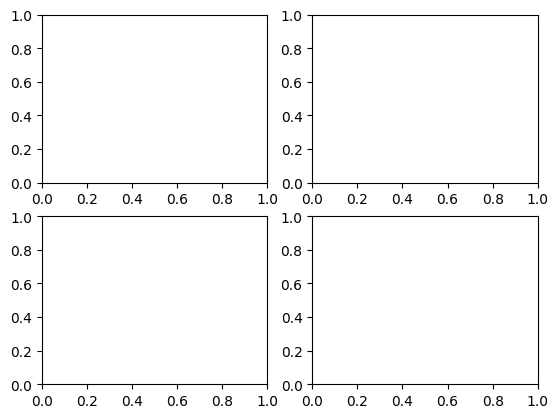

In [134]:
model.load_replay_buffer('/data/bing/hendrik/reach10rpl')
init_policy(model)
qenv.replay_data = MDPData(device=device)
qenv.first_observations = copy.deepcopy(qenv_eval.first_observations[:100])
qenv.set_initial_phase(model, True)
tb = TBoardGraphs(logname='Initial Phase', data_path='/data/bing/hendrik/')
qenv.set_predictive_mode(False, model)
test_gradient_steps_SAC(model=model, tboard=tb, env=qenv)

In [135]:
qenv.set_initial_phase(model, False)

/tmp/ipykernel_23394/3580556201.py:619: RuntimeWarning: Mean of empty slice.
  tb.addValidationScalar(name='Average Reward', value=th.tensor(rews_np.mean()), stepid=iteration)
/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
_______________
1
_______________
2
_______________
3
_______________
4
_______________
5
_______________
6
_______________
7
_______________
8
_______________
9
_______________
10
_______________
11
_______________
12
_______________
13
_______________
14
_______________
0
_______________
1
_______________
2
_______________
3
_______________
4
_______________
5
_______________
6
_______________
7
_______________
8
_______________
9
_______________
10
_______________
11
_______________
12
_______________
13
_______________
14
_______________
0
_______________
1
_______________
2
_______________
3
_______________
4
_______________
5
_______________
6
_______________
7
_______________
8
_______________
9
_______________
10
_______________
11
_______________
12
_______________


KeyboardInterrupt: 

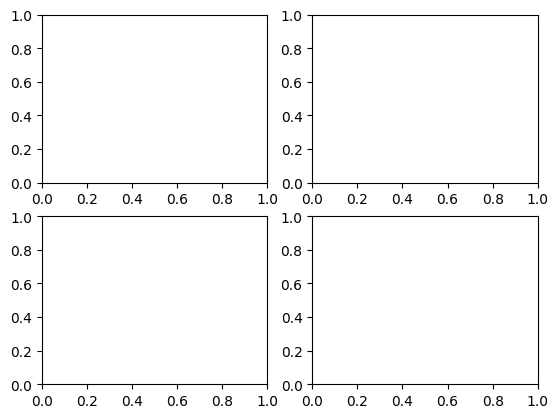

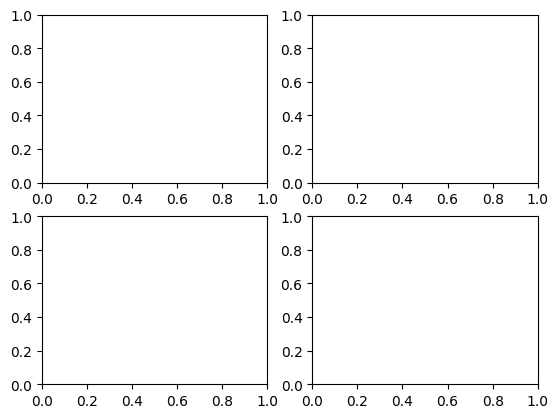

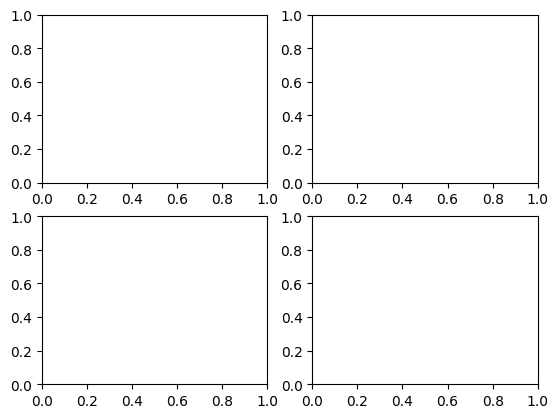

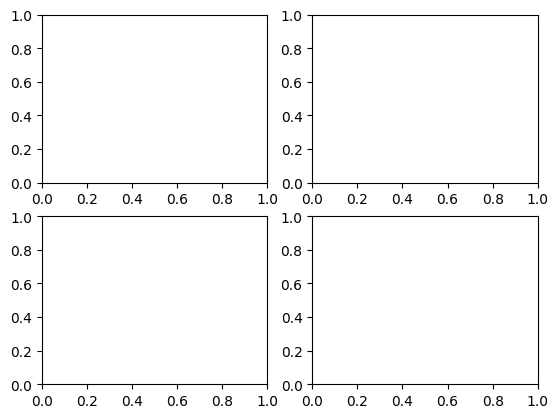

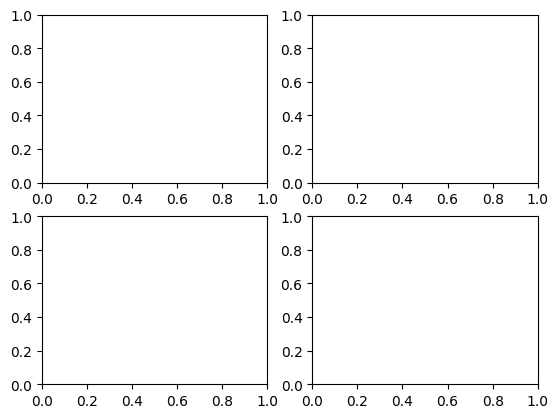

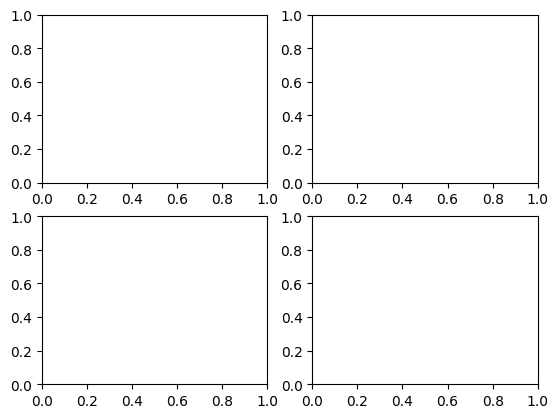

In [136]:
model.load_replay_buffer('/data/bing/hendrik/reach10rpl')
init_policy(model)
qenv.replay_data = MDPData(device=device)
qenv.first_observations = copy.deepcopy(qenv_eval.first_observations[:100])
test_SAC(env=qenv, eval_env=qenv_eval, eval_epochs=0, iterations=1, logname='reach 1 super', path='/data/bing/hendrik/', model=model, device=device, lf=10)

for i in range(10):
    tb = TBoardGraphs(logname='Train Steps' + str(10 * (i+1)), data_path='/data/bing/hendrik/')
    qenv.set_predictive_mode(False, model)
    test_gradient_steps_SAC(model=model, tboard=tb, env=qenv)
    qenv.set_predictive_mode(True, model)
    test_SAC(env=qenv, eval_env=qenv_eval, eval_epochs=0, iterations=1, logname='reach 1 super', path='/data/bing/hendrik/', model=model, device=device, lf=1)


In [130]:
len(qenv_eval.first_observations)

220

In [ ]:
qenv_new = QuantzedMDP(env=env, ntokens_obsv=1000, ntokens_act=1000, obsv_low=-1, obsv_high=1, action_low=-1, action_high=1, device=device, mdpLearner=mdp_learner)

In [ ]:
qenv_new.mdpLearner = n_mdp

In [ ]:
qenv_new.set_predictive_mode(False, model)

In [ ]:
model.policy.actor

In [ ]:
compare_prediction_and_simulation(qenv_new, tb, step=8, model=model)

In [ ]:
model.replay_buffer.observations[10002]

In [ ]:
qenv_new.predict_MDP = False

In [ ]:
qenv_new.mdpLearner = qenv.mdpLearner

In [ ]:
rews = test_policy(model, qenv_new, iterations=40)
rews.mean()

In [ ]:
rpb = model.replay_buffer

In [ ]:
pkwarg = dict(features_extractor_class=TestExtractor)
model = SAC("MlpPolicy", qenv, verbose=1, policy_kwargs=pkwarg)
model.learn(1)

In [ ]:
model.replay_buffer = rpb

In [ ]:
qenv.set_predictive_mode(False, model)

In [ ]:
th.autograd.set_detect_anomaly(True)

In [ ]:
model.train(gradient_steps=1000)

In [ ]:
compare_prediction_and_simulation(qenv=qenv_eval, tb=tb, step=2, model=model)

In [ ]:
qenv.replay_data.obsv.shape

In [ ]:
qenv.set_predictive_mode(predict=True, sac=model)

In [ ]:
qenv_eval.mdpLearner = qenv.mdpLearner

In [ ]:
qenv_eval.predict_MDP = True

In [ ]:
qenv_eval.first_observations = qenv.first_observations

In [ ]:
#qenv.set_predictive_mode(predict=False, sac=model)

In [ ]:
init_policy(model=model)
#model.train(gradient_steps=10)

In [ ]:
import copy

In [ ]:
init_replay_buffer = copy.deepcopy(model.replay_buffer)

In [ ]:
init_model_params = model.get_parameters()

In [ ]:
init_replay_buffer.pos

In [ ]:
new_obsv = qenv.reset()

In [ ]:
my_list = qenv.first_observations[:]

In [ ]:
qenv_eval.first_observations = [new_obsv]

In [ ]:
qenv.first_observations = [new_obsv]

In [ ]:
qenv.set_predictive_mode(predict=True, sac=model)

In [ ]:
qenv_eval.predict_MDP = True

In [ ]:
model.replay_buffer = init_replay_buffer

In [ ]:
model.train(gradient_steps=10000)

In [ ]:
qenv_eval.mdpLearner = qenv.mdpLearner

In [ ]:
qenv_eval.predict_MDP = False

In [ ]:
env

In [ ]:

rews = test_policy(model=model, env=qenv_eval, iterations=40)

In [ ]:
rews.mean()

In [ ]:
qenv_eval.predict_MDP

In [ ]:
qenv.predict_MDP

In [ ]:
qenv_eval.set_predictive_mode(predict=True, sac=model)
qenv_eval.mdpLearner = qenv.mdpLearner
qenv.set_predictive_mode(predict=True, sac=model)

In [ ]:
model = None

In [ ]:
model = test_SAC(env=qenv, eval_env=qenv_eval, eval_epochs=20, iterations=1, logname='reach 1 predicted', path='/data/bing/hendrik/', model=None, device=device)

In [ ]:
init_policy(model)
model.replay_buffer = init_replay_buffer

In [ ]:
init_replay_buffer = copy.deepcopy(model.replay_buffer)

In [ ]:
model.replay_buffer.pos

In [ ]:
model = test_SAC(env=qenv, eval_env=qenv_eval, eval_epochs=20, iterations=1, logname=
'reach 1 predicted', path='/data/bing/hendrik/', model=None, device=device)

In [ ]:
model.replay_buffer = init_replay_buffer

In [ ]:
model.replay_buffer.pos

In [ ]:
model = test_SAC(env=qenv, eval_env=qenv_eval, eval_epochs=20, iterations=5, logname='reach 1 predicted', path='/data/bing/hendrik/', model=model, device=device)

In [ ]:
init_policy(model=model)

In [ ]:
model.replay_buffer.pos

In [ ]:
model.train(gradient_steps=15000)

In [ ]:
qenv_eval.set_predictive_mode(predict=False, sac=model)
qenv_eval.mdpLearner = qenv.mdpLearner
qenv.set_predictive_mode(predict=False, sac=model)

In [ ]:
rews = test_policy(model=model, env=qenv_eval, iterations=160)

In [ ]:
rews.mean()

In [ ]:
rews = test_policy_initial_state(model=model, envs=[qenv], obsvs=[new_obsv])

In [ ]:
rews.mean()

In [ ]:
#init_policy(model=model)
rews = test_policy(model=model, env=qenv_eval, iterations=20)

In [ ]:
rews.mean()

In [ ]:
qenv_eval.predict_MDP = False

In [ ]:
rews = []
obs = qenv_eval.reset()
while True:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = qenv_eval.step(action)
    rews.append(reward)
    #env.render()
    if done:
        break
rews = np.array(rews)

In [ ]:
def createGraphs(tboard, trjs:list([th.tensor]), trj_names:list([str]), plot_name:str, step):
    np_trjs = []
    trj_colors = ['forestgreen', 'orange', 'pink']
    for trj in trjs:
        np_trjs.append(trj.detach().cpu().numpy())
    tboard.plot_graph(trjs=np_trjs, trj_names=trj_names, trj_colors=trj_colors, plot_name=plot_name, step=step)

In [ ]:
qenv_eval.replay_data.obsv.shape

In [ ]:
pred_rews = mdp_learner.pred_rewards(obsvs=qenv.replay_data.obsv[-100:].unsqueeze(1), actions=qenv.replay_data.action[-100:].unsqueeze(1))

In [ ]:
pred_rews = th.tensor(pred_rews.reshape(-1, 1)).to('cpu')

In [ ]:
rews = th.tensor(rews.reshape(-1, 1)).to('cpu')

In [ ]:
((pred_rews-rews)**2).mean()

In [ ]:
qenv.replay_data.action[-100:]

In [ ]:
rews

In [ ]:
pred_rews

In [ ]:
pred_rews.shape

In [ ]:
createGraphs(tboard=tb, trjs=[rews, pred_rews], trj_names=['rews', 'pred_rews'], step=0, plot_name='Rewards')

In [ ]:
model.replay_buffer.pos

In [ ]:
model.total_gradient_steps

In [ ]:
tb = TBoardGraphs(logname='SAC reach test gradient steps', data_path='/data/bing/hendrik/')

In [ ]:
test_gradient_steps_SAC(model=model, tboard=tb, env=qenv_eval)

In [ ]:
model.train(gradient_steps=model.total_gradient_steps, batch_size=model.batch_size)

In [ ]:
rews = []
eval_epochs = 20
env = qenv
for eval_run in range(eval_epochs):
    obs = env.reset()
    while True:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        rews.append(reward)
        #env.render()
        if done:
            break
rews_np = np.array(rews)